## Creating Environment

In this notebook I replicate a time series approach using tensorflow and keras, which was published by A.K.A Niyamat Ullah under the title "Machine Learning for time series analysis". You can find the blog entry on https://www.kaggle.com/niyamatalmass/machine-learning-for-time-series-analysis (Last access 2018-05-11)

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import seaborn as sns
import numpy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

D:\installation\programs\Anaconda\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
input = pd.read_csv('testset.csv', sep = ',', compression = 'bz2')
input['date'] =  pd.to_datetime(input['date'])
input.dtypes

Unnamed: 0             int64
date          datetime64[ns]
price_usd            float64
amount_usd           float64
amount_btc           float64
dtype: object

## Creating Time Series Object and Plotting Data

The dataset contains different prices for the same date. In the next step we collaps the data and mean the prices.

In [21]:
input['date'] =  input['date'].dt.floor('d')
btc_price_usd = input.set_index('date').groupby(pd.Grouper(freq='d')).mean().dropna(how='all').price_usd

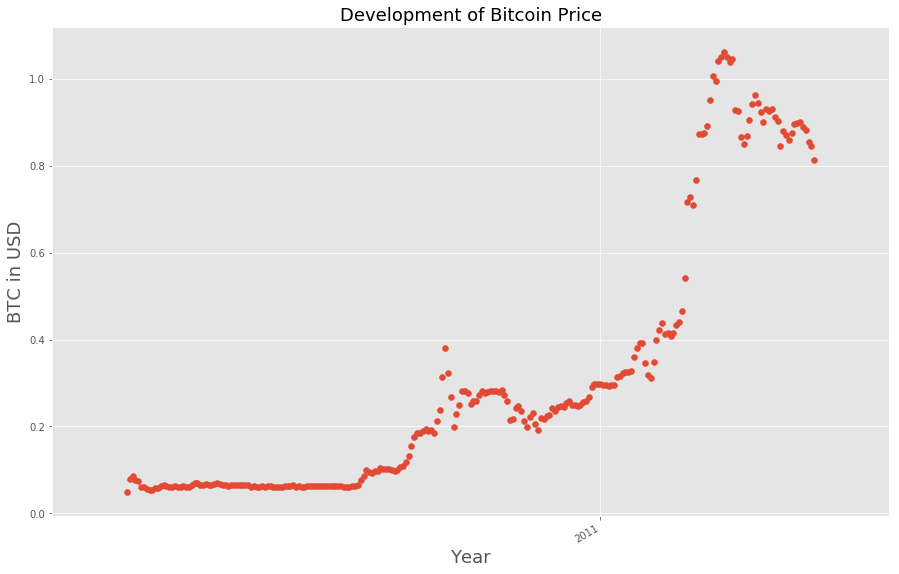

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(btc_price_usd.index, btc_price_usd)
# change x axis year location interval to 1 year. So that it displays data in interval of 1 year
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# Add the title to the graph
plt.title('Development of Bitcoin Price', fontsize=18)
# add xlabel
plt.xlabel('Year', fontsize=18)
# add ylabel
plt.ylabel('BTC in USD', fontsize=18)
# beautify the x axis date presentation
fig.autofmt_xdate()
# And finally show the plot in a new window.
plt.show()


## Load Function from Blog

In [23]:
# frame a sequence as a supervised learning problem
# this methods will create a column and column value will be 1 shift from the data. 
# it will make our data to supervised so that we can feed into network
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [24]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [25]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [26]:
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [27]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


In [28]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [29]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size, verbose=0)
	return yhat[0,0]

## Processing Data

In [30]:
# convert our column to pandas series 
series = pd.Series(btc_price_usd)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.66)
train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

## Model Training

In [31]:
# repeat 30 times
repeats = 30
# variable for keep track of error scores
error_scores = list()
for r in range(repeats):
    # let's train
    lstm_model = fit_lstm(train_scaled, 1, 30, 4)
    predictions = list()
    # let's predict for test case
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 0.007
2) Test RMSE: 0.008
3) Test RMSE: 0.008
4) Test RMSE: 0.008
5) Test RMSE: 0.007
6) Test RMSE: 0.006
7) Test RMSE: 0.004
8) Test RMSE: 0.005
9) Test RMSE: 0.007
10) Test RMSE: 0.005
11) Test RMSE: 0.007
12) Test RMSE: 0.007
13) Test RMSE: 0.008
14) Test RMSE: 0.007
15) Test RMSE: 0.008
16) Test RMSE: 0.008
17) Test RMSE: 0.006
18) Test RMSE: 0.007
19) Test RMSE: 0.007
20) Test RMSE: 0.007
21) Test RMSE: 0.005
22) Test RMSE: 0.009
23) Test RMSE: 0.005
24) Test RMSE: 0.006
25) Test RMSE: 0.008
26) Test RMSE: 0.007
27) Test RMSE: 0.007
28) Test RMSE: 0.005
29) Test RMSE: 0.009
30) Test RMSE: 0.006


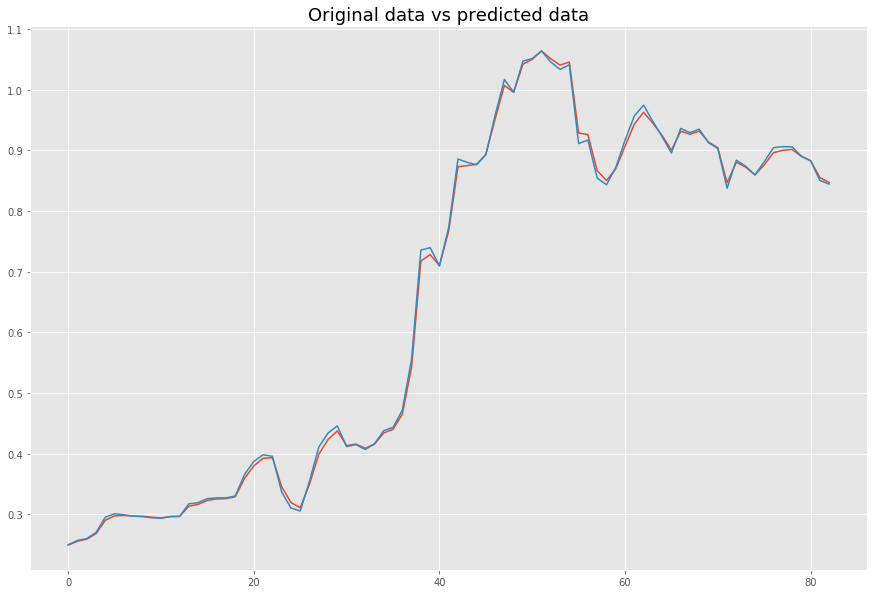

In [34]:
# report performance
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
# print(results.describe())
# results.boxplot()
# plt.show()

# line plot of observed vs predicted
plt.figure(figsize=(15, 10))
plt.plot(raw_values[train_size:len(supervised_values)])
plt.plot(predictions)
plt.title('Original data vs predicted data', fontsize=18)
plt.show()

In [57]:
# last value of our dataset
f = np.array(btc_price_usd[-1])
# sklearn minmaxscaler for converting "f" to range to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# minmaxscaler fit
scaler = scaler.fit(f)
# let's transform
train = f.reshape(1, 1)
train_scaled = scaler.transform(train)

## Use model for prediction

In [58]:
# initial record
initial = train_scaled
# store prediction
prediction = []
# range 40 because we want the prediction for next 40 months
for i in range(40):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = scaler.inverse_transform(yhat)
    # append to our prediction variable
    prediction.append(yhat_inver)
    # re initial our initial variable so that it feed the current predicted value as input for forecast
    initial = np.array([yhat])

In [59]:
prediction = np.concatenate(prediction, axis=0 ).tolist()
prediction = [item for sublist in prediction for item in sublist]
prediction = pd.DataFrame(prediction)

In [60]:
rng = pd.date_range('2011-03-15 00:00:00', periods=40, freq='D')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.set_index('0_x')
prediction.columns = ['date', 'btc_price_usd']
prediction

date  btc_price_usd
0  2011-03-15       1.216105
1  2011-03-16       1.249245
2  2011-03-17       1.273042
3  2011-03-18       1.291257
4  2011-03-19       1.304278
5  2011-03-20       1.312816
6  2011-03-21       1.317688
7  2011-03-22       1.319704
8  2011-03-23       1.319604
9  2011-03-24       1.318028
10 2011-03-25       1.315511
11 2011-03-26       1.312486
12 2011-03-27       1.309294
13 2011-03-28       1.306191
14 2011-03-29       1.303359
15 2011-03-30       1.300912
16 2011-03-31       1.298911
17 2011-04-01       1.297369
18 2011-04-02       1.296267
19 2011-04-03       1.295562
20 2011-04-04       1.295196
21 2011-04-05       1.295104
22 2011-04-06       1.295219
23 2011-04-07       1.295482
24 2011-04-08       1.295837
25 2011-04-09       1.296238
26 2011-04-10       1.296650
27 2011-04-11       1.297044
28 2011-04-12       1.297402
29 2011-04-13       1.297712
30 2011-04-14       1.297969
31 2011-04-15       1.298170
32 2011-04-16       1.298320
33 2011-04-17       1.298423
34 2011-04-18       1.298486
35 2011-04-19       1.298515
36 2011-04-20       1.298519
37 2011-04-21       1.298503
38 2011-04-22       1.298475
39 2011-04-23       1.298438

In [61]:
original = pd.DataFrame({'date':btc_price_usd.index, 'btc_price_usd':btc_price_usd.values})
original

btc_price_usd       date
0         0.049510 2010-07-17
1         0.079548 2010-07-18
2         0.085230 2010-07-19
3         0.077005 2010-07-20
4         0.074167 2010-07-21
5         0.061641 2010-07-22
6         0.061197 2010-07-23
7         0.055113 2010-07-24
8         0.053991 2010-07-25
9         0.053475 2010-07-26
10        0.058959 2010-07-27
11        0.058257 2010-07-28
12        0.063730 2010-07-29
13        0.065165 2010-07-30
14        0.061909 2010-07-31
15        0.061065 2010-08-01
16        0.061605 2010-08-02
17        0.061889 2010-08-03
18        0.059709 2010-08-04
19        0.060105 2010-08-05
20        0.062000 2010-08-06
21        0.060473 2010-08-07
22        0.060275 2010-08-08
23        0.066245 2010-08-09
24        0.069184 2010-08-10
25        0.069892 2010-08-11
26        0.065967 2010-08-12
27        0.065556 2010-08-13
28        0.067263 2010-08-14
29        0.065575 2010-08-15
..             ...        ...
215       1.045398 2011-02-17
216       0.928406 2011-02-18
217       0.925889 2011-02-19
218       0.866578 2011-02-20
219       0.850102 2011-02-21
220       0.869274 2011-02-22
221       0.906441 2011-02-23
222       0.943046 2011-02-24
223       0.962626 2011-02-25
224       0.944661 2011-02-26
225       0.924246 2011-02-27
226       0.900141 2011-02-28
227       0.931259 2011-03-01
228       0.926462 2011-03-02
229       0.931525 2011-03-03
230       0.913483 2011-03-04
231       0.904153 2011-03-05
232       0.846484 2011-03-06
233       0.880378 2011-03-07
234       0.872091 2011-03-08
235       0.859317 2011-03-09
236       0.875775 2011-03-10
237       0.896051 2011-03-11
238       0.899849 2011-03-12
239       0.901374 2011-03-13
240       0.889910 2011-03-14
241       0.882888 2011-03-15
242       0.854964 2011-03-16
243       0.846801 2011-03-17
244       0.813058 2011-03-18

[245 rows x 2 columns]

In [62]:
frames = [original, prediction]
df_final = pd.concat(frames)
df_final.set_index(['date'],inplace=True)

In [63]:
df_final = pd.Series(df_final.btc_price_usd)

In [64]:
plt.rc('figure', figsize=(15, 10))

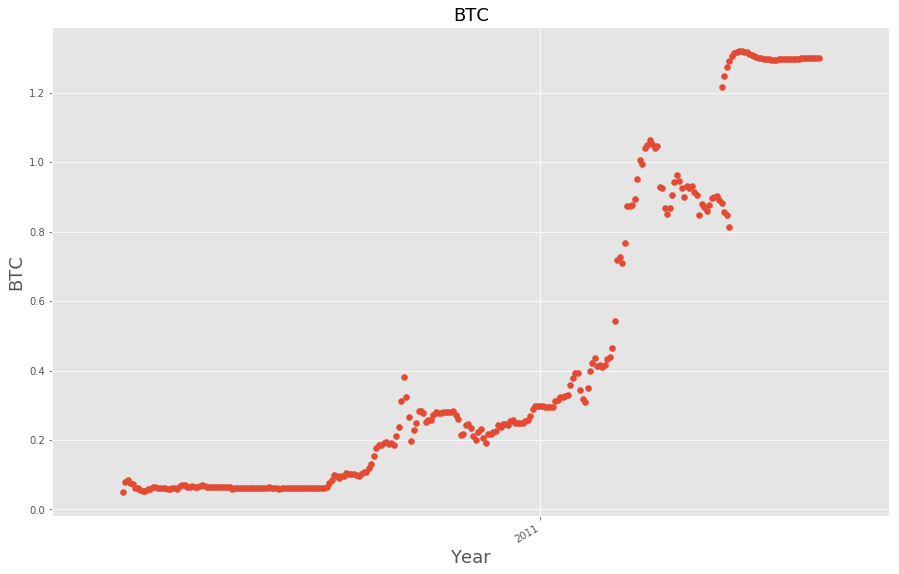

In [65]:
# df_final.plot(figsize=(15, 5),x_compat=True)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_final.index, df_final)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('BTC', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylabel('BTC', fontsize=18)
fig.autofmt_xdate()
plt.show()


## Conclusion

The model works, but the variation in the price is way to small. The process of learning the model took quite some time. (more than 5 minutes i would guess.